In [288]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Ginni :
$H(R_m) = 1 - \sum_{k = 1}^K p_{mk}^2$

Entropy:
$H(p) = -\sum_{k = 1}^{K} p_k \log_2 p_k$

$$
    Q(R_m, j, s) = H(p_m) - \frac{N_\ell}{N_m} H(p_\ell) - \frac{N_r}{N_m} H(p_r),
$$
где $p_i = (p_{i1}, \dots, p_{iK})$ - распределение классов в $i$-й вершине.
Видно, что данный критерий отдает предпочтение более "вырожденным" распределениям
классов.

In [302]:
class GreedyAndUglyTreeButHeWork():
  def __init__(self, values, targets):
    self.tree = {}
    self.tree_dict = {}
    self.targets = targets
    self.values = values.T
    self.criterion = 'ginni'
    self.deep = 0
    self.end_tree = {}
  def inf_crit(self, p):
    if self.criterion == 'ginni':
      return self.ginni(p)
    if self.criterion == 'entropy':
      return self.entropy(p)

  def informative_function(self,targets):

    def p_targets(targets, unice_targets):
      #calculate p for all targets 
      p_targets = []
      len_targets = len(targets)
      for target in unice_targets:
        p_targets.append(len(targets[targets == target])/len_targets)
      return p_targets
    def information_value(L_quantity,R_quantity,quantity,L_probabilities,R_probabilities, all_targets_crit):
      #calculate infomation value
      return self.inf_crit(all_targets_crit) - L_quantity*self.inf_crit(L_probabilities)/quantity - R_quantity*self.inf_crit(R_probabilities)/quantity
    
    N = len(targets)
    best_partition = [0,0]
    unicue_targets = np.unique(targets)

    left_prob = []
    right_prob = []
    all_targets_crit = p_targets(targets, unicue_targets)

    for n in range(N-1):

      left_prob = p_targets(targets[:n+1], unicue_targets)
      right_prob = p_targets(targets[n+1:], unicue_targets)

      #calculate infomation value
      inf_value = information_value(n+1, N-1-n, N, left_prob, right_prob, all_targets_crit)

      if inf_value > best_partition[0]:
        best_partition = inf_value, n+1
    return best_partition

  def ginni(self,p):
    p = np.array(p)
    return 1 - np.sum(p*p)
  def entropy(self,p):
    p = np.array(p)
    return - np.sum(p*np.log(p))

  def fit(self,depth = 100, criterion = 'entropy'):

    def tree_function(values,targets):
      targets = targets.reshape(1,len(targets))
      val_tar = np.concatenate([values, targets], axis = 0).T
      left_result = {}
      right_result = {}
      inf_crit = {}
      best_result = [0,0]
      for f in range(len(values)):
        
        sort_val_tar = val_tar[val_tar[:,f].argsort()[::-1]].T

        informative_targets = self.informative_function(sort_val_tar[-1])
        if informative_targets[0] > best_result[0]:
          best_result = informative_targets

          left_result['values'] = sort_val_tar[:-1,:best_result[1]]
          left_result['targets'] = sort_val_tar[-1][:best_result[1]]

          
          right_result['values'] = sort_val_tar[:-1,best_result[1]:]
          right_result['targets'] = sort_val_tar[-1][best_result[1]:]

          inf_crit['inf_crit'] = informative_targets[0]
          inf_crit['Nomber_of_values'] = informative_targets[1]
          inf_crit['name_of_values'] = f
          inf_crit['edge_of_value'] = sort_val_tar[f][informative_targets[1]]

      
        
      
      
      return left_result, right_result, inf_crit

    self.tree_dict[0] = {}
    self.tree_dict[0]['start'] = {'values':self.values,'targets': self.targets}
    while(True):
      
      self.tree_dict[self.deep + 1] = {}
      for key in self.tree_dict[self.deep]:

        if 'information_criteria' in key:
          continue         
        if len(np.unique(self.tree_dict[self.deep][key]['targets'])) == 1:
          continue
        values = self.tree_dict[self.deep][key]['values']
        targets = self.tree_dict[self.deep][key]['targets']
        l_and_r = tree_function(values, targets)
        self.tree_dict[self.deep + 1][f'left {key}'] = l_and_r[0]
        self.tree_dict[self.deep + 1][f'right {key}'] = l_and_r[1]
        self.tree_dict[self.deep + 1][f'information_criteria {key}'] = l_and_r[2]

      if self.tree_dict[self.deep + 1] == {}:
        break
      self.deep += 1

    for n in self.tree_dict:
      for i in self.tree_dict[n]:
        if 'information_criteria' in i:
          print(i)
          print(self.tree_dict[n][i]['name_of_values'])
          print(self.tree_dict[n][i]['edge_of_value'])
          self.end_tree

  def classicator(self, data):
    path = 'start'
    path_deep = 0
    for deep in self.tree_dict:
      try:
        feature = self.tree_dict[deep][f'information_criteria {path}']['name_of_values']
        value = self.tree_dict[deep][f'information_criteria {path}']['edge_of_value']
        if data[feature] <= value:
          path = 'right ' + path
        else:
          path = 'left ' + path
        path_deep += 1
      except:
        pass
    targets = self.tree_dict[path_deep][path]['targets']
    name_of_class = int(sum(targets)/len(targets))
    return name_of_class
  def predict(self, data):
    list_of_classes = []
    for string in data:
      list_of_classes.append(self.classicator(string))

    return list_of_classes
  

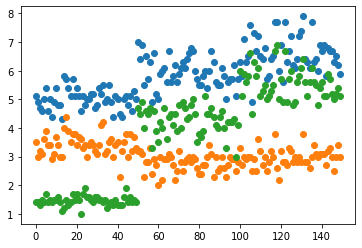

In [309]:

from sklearn.datasets import load_iris
data = load_iris()
values = data.data
targets = data.target


X_train, X_test, y_train, y_test = train_test_split(values, targets, test_size=0.2)

plt.plot(values.T[0],'o')
plt.plot(values.T[1],'o')
plt.plot(values.T[2],'o')

In [310]:
tree = GreedyAndUglyTreeButHeWork(X_train, y_train)

In [311]:
tree.fit()

information_criteria start
2
1.9
information_criteria left start
2
4.9
information_criteria left left start
3
1.6
information_criteria right left start
3
1.6
information_criteria right left left start
0
6.0
information_criteria left right left start
1
3.0


In [312]:
print(list(y_test))
print(tree.predict(X_test))

[2, 0, 0, 1, 2, 1, 0, 0, 1, 0, 2, 1, 2, 2, 1, 2, 2, 1, 1, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0]
[2, 0, 0, 1, 2, 2, 0, 0, 1, 0, 2, 1, 2, 2, 1, 2, 2, 1, 1, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0]
